# **Data Analysis For Calibration Data**

This Contains the analysis and code for determining the Charge Per Reset from UTA's SAQ Test Stand Calibration data, where 4 different currents were input into each of 14 SAQ chips and the resets recorded. This code is designed to pull from a folder called "Data" which is also in this github, and contains the calibration data in the form of root files, that are saved from Kevin Keefes GUI, that reads reset data from the Zybo.. This contains the following Analysis procedures:

## 1. Reading from Root files and getting Timestamps of Resets:
   
 - Parsing information from the 16 channels
 - Discarding the first packet from the zybo (this was a bug that would keep the left over timestamp from the last run if the GUI wasnt closed properly)
 - Converting from Zybo-timestamp to timestamp in seconds
 - Doing this for all 4 input currents and daving it all to a 3d list

## 2. Plot the Number of Resets vs Time:
   
 - Plotting how many resets are coming in over time so you can see if there are any stops in the data where resets werent being collected
   
## 3. Get the Reset Time differences and plotting:

 - Getting the reset time differences (RTDs) from the timestamps
 - Finding the mean RTD and 1 standard deviation and saving that information

## 4. Calculating Charge Per Reset from Calibration Data:

 - Plotting the input current vs 1/meanRTD, and propagating errors
 - Fitting a line to that data 
 - Finding the slope of the line using a weighted polynomial regression fit (This slope is the Charge Per Reset)
 - Getting the error on the slope fit

## 5. Comparing Charge Per Reset to Vdd Values:

 - Generating a plot comparing Charge per reset vs Vdd value so you can see how the shapes correspond (They should be closely related)


In [1]:
import matplotlib.pyplot as plt
import ast
import numpy as np
import  os
from pathlib import Path
import os
import sys
import ROOT
import numpy as np
from SAQ_DAQ import N_SAQ_CHANNELS

Welcome to JupyROOT 6.26/04


## 1. Reading From Root Files and getting Timestamps of Resets:

In [2]:
def fix_wrap_around(times):
    """
    update timestamp values from the zybo
    every timestamp that is less than the previous indicates a 'wrap around'
    """

    wrap_val = 2**32
    n_wrap = 0
    inc_times = [times[0]]
    for i, t in enumerate(times[:-1]):

        if times[i+1] < t:
            n_wrap += 1

        cur_time = times[i+1] + (n_wrap * wrap_val)
        inc_times.append(cur_time)

    return inc_times


def filter_saq(resets, SAQ_DIV, ZYBO_FRQ, setXtoTime, noiseFil, min_time=0.000020, min_binBit=0):
    """
    Ensure that resets time differences exclude impossible minimum time from
    length of reset pulse.
    ARGS:
       resets       : list of 32bit timestamp values from Zybo
       SAQ_DIV      : clock division register on the zybo. This should be read in from metadata
       ZYBO_FRQ     : zybo norminal frequecy in hertz. This should be read in from metadata
       min_time     : time in seconds of reset pulse width, default is 10us from SAQ
       min_binBit   :
       noiseFil     : boolean, determines whether noise is filtered
    RETURNS:
       rtds         : parsed list of reset time differences
    """
    assert isinstance(resets, list), "expect a list of resets to act on"
    # build the reset list with RTDs
    rtds = []
    iLastReset = 0
    if not resets:
    	times = [0]
    else:
        times = [resets[iLastReset]]
    for i, r in enumerate(resets[:-1]):
        rtd = resets[i + 1] - resets[iLastReset]
        if rtd < 0:
            rtd += 2 ** 32
        if noiseFil ==True:
            if (rtd * SAQ_DIV) / ZYBO_FRQ > min_time and rtd > min_binBit:
                if setXtoTime == True:
                    rtds.append((rtd * SAQ_DIV) / ZYBO_FRQ)
                if setXtoTime == False:
                    rtds.append(rtd)
                times.append(resets[i+1])
               	iLastReset = i + 1
        else:
            if (rtd * SAQ_DIV) / ZYBO_FRQ > min_time:
                if setXtoTime == True:
                    rtds.append((rtd * SAQ_DIV)/ ZYBO_FRQ)
                if setXtoTime == False:
                    rtds.append(rtd)
                    print("False")
                times.append(resets[i+1])
               	iLastReset = i + 1
  	
    
    return rtds, fix_wrap_around(times)

dir=str(os.path.join(os.getcwd(), 'Data'))
input_files = [os.path.join(dir, f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) and '.root' in f]

p01nA = [[] for _ in range(14)]
p07nA = [[] for _ in range(14)]
p1nA = [[] for _ in range(14)]
p5nA = [[] for _ in range(14)]

for input_file in input_files:
    
    ROOT.EnableImplicitMT()  # gotta go fast

    # open up ttree into an rdataframe, which is easy to convert to a list
    rdf = ROOT.RDataFrame("tt", input_file)

    # rip everything immediately into a dictionary, where the keys are
    # the branch names
    data = rdf.AsNumpy()

    # numpy arrays of the data we need
    pid=data["pid"]
    f = pid!=pid[0]
    ts = data["Timestamp"][f]
    masks = data["ChMask"][f]

    # snag the meta data from the tfile
    # these values are defined in make_root.py script when ROOT file is created
    # from binary
    tf = ROOT.TFile(input_file, "READ")
    meta_data = tf.mt
    SAQ_DIV = -1
    ZYBO_FRQ = -1
    version = 0

    # Grab these settings from the tf file
    for evt in meta_data:
        SAQ_DIV = evt.SAQ_DIV
        version = evt.Version
        ZYBO_FRQ = evt.Zybo_FRQ
    assert version >= 0x3f, f"version of root file is too old! 0x{version:02x} <= 0x3f"
    # assert SAQ_DIV >= 1, f"SAQ_DIV not properly defined: {SAQ_DIV} not >= 1"
   
    assert ZYBO_FRQ >= 30e6, f"ZYBO_FRQ not properly defined: {ZYBO_FRQ} not >= 30 MHz"

    # make a quick way to ensure the channel we want is in the mask
    m = lambda ch, mask: 1 << ch & mask

    # create a list of the channels and all of their resets
    chResets = [[t for t, mask in zip(ts, masks) if m(ch, mask)] for ch in range(N_SAQ_CHANNELS)]

    # chRTD is a list of a list where the first index is the channel number -1
    # (lists are zero counted), which contain the sequential time since last
    # reset data

    setXtoTime = True
    noiseFil = False
    chRTDTimes = [filter_saq(r, SAQ_DIV, ZYBO_FRQ, setXtoTime, noiseFil) for r in chResets]
    chTimes = [times for rtds, times in chRTDTimes]
    
    #convert sybo timestamp to actual time
    chTimes =[[timestamp * 200 / 30e6 for timestamp in inner_list] for inner_list in chTimes]

    # we have four input currents, get the input current and channel number (start from 0) from the header 
    # assign that to the appropriate list/channel
    fileName=input_file.split(".root")[0].split('/')[-1]

    if "p01nA" in fileName:
        chNum = int(fileName.split('Ch')[-1].split('_')[0]) - 1
        #only get the ch that has input current, the other channels should have no resets
        p01nA[chNum] = chTimes[chNum]
    if "p07nA" in fileName:
        chNum = int(fileName.split('Ch')[-1].split('_')[0]) - 1
        #only get the ch that has input current, the other channels should have no resets
        p07nA[chNum] = chTimes[chNum]
    if "p1nA" in fileName:
        chNum = int(fileName.split('Ch')[-1].split('_')[0]) - 1
        #only get the ch that has input current, the other channels should have no resets
        p1nA[chNum] = chTimes[chNum]
    if "p5nA" in fileName:
        chNum = int(fileName.split('Ch')[-1].split('_')[0]) - 1
        #only get the ch that has input current, the other channels should have no resets
        p5nA[chNum] = chTimes[chNum]
        
allInputCurrents = [p01nA, p07nA, p1nA, p5nA]  #contains a 3d list with 4 lists each containting 14 lists for each channel

## 2. Plot the Number of Resets vs Time:

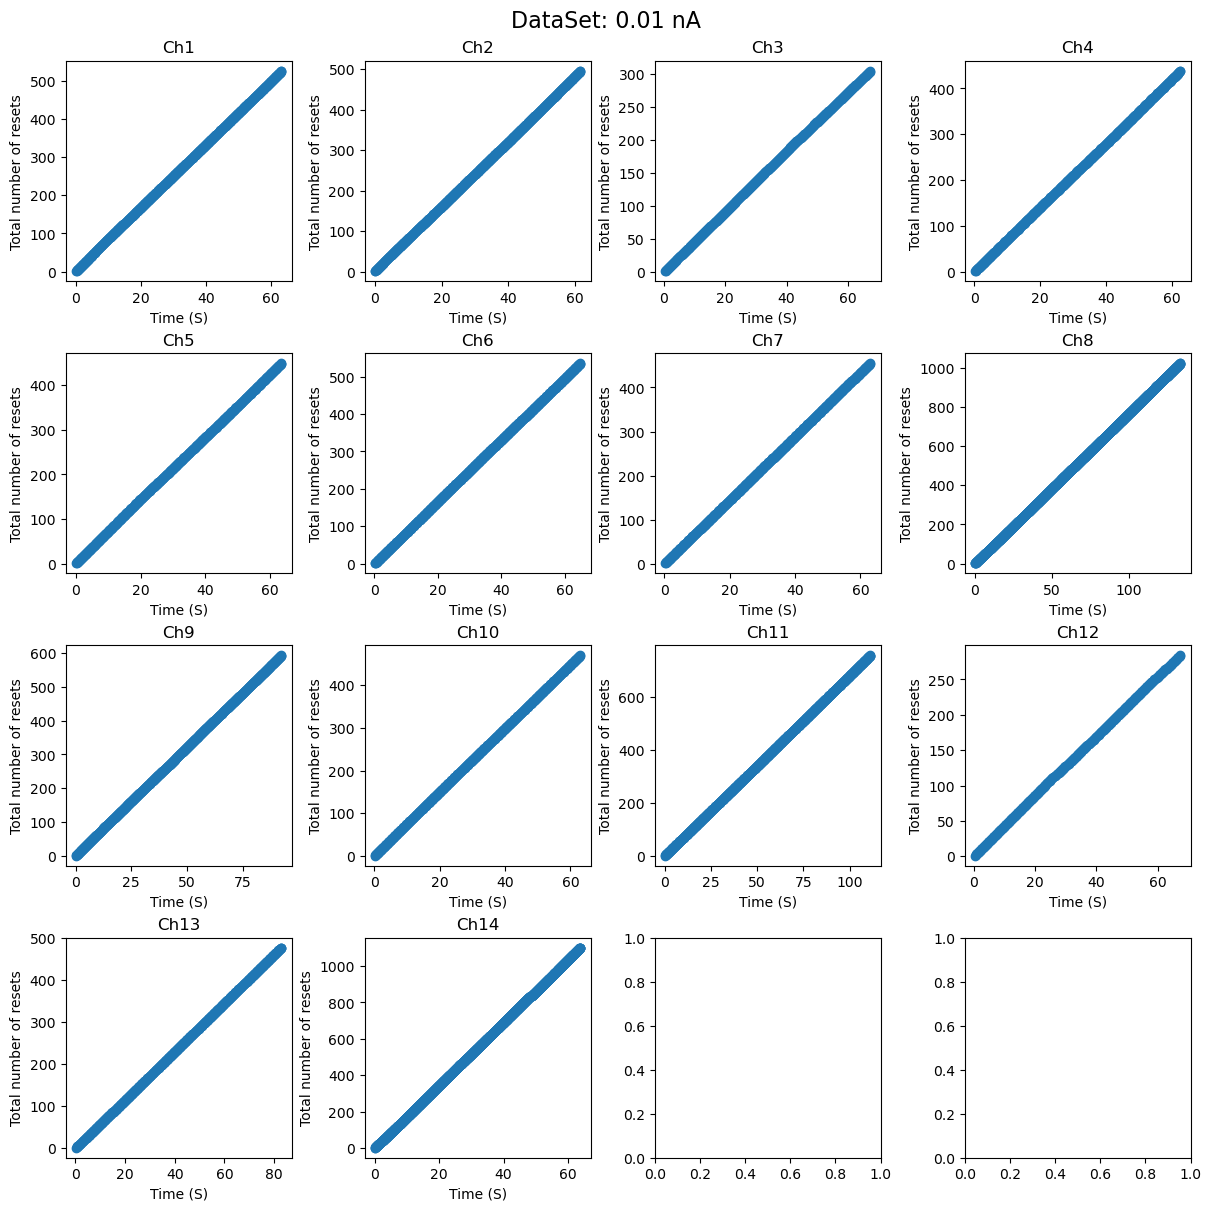

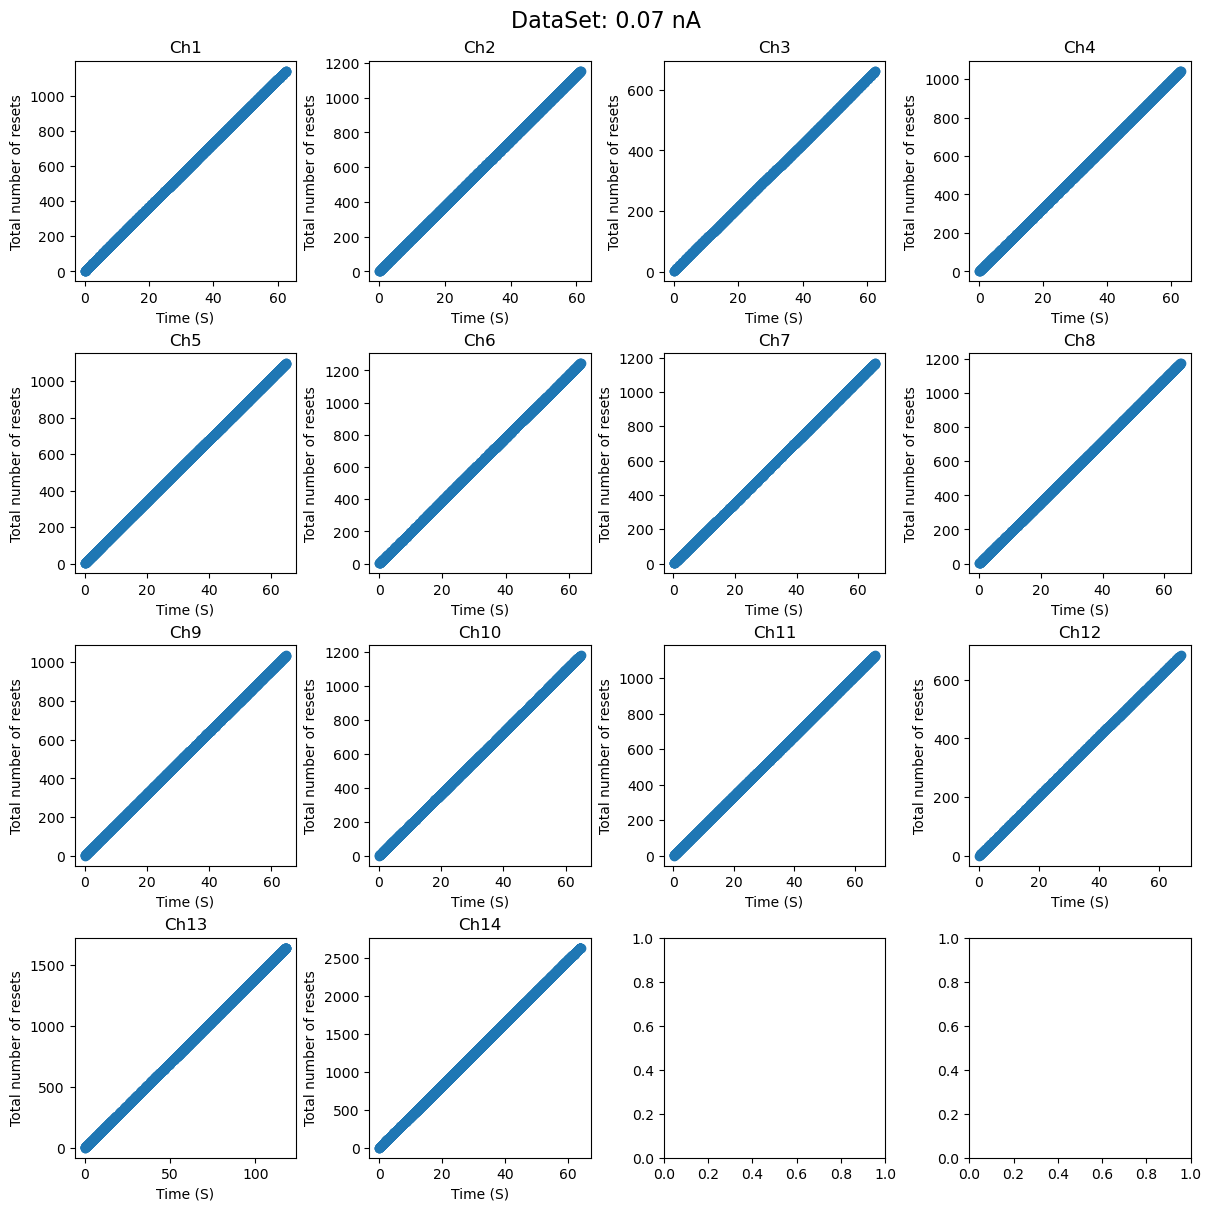

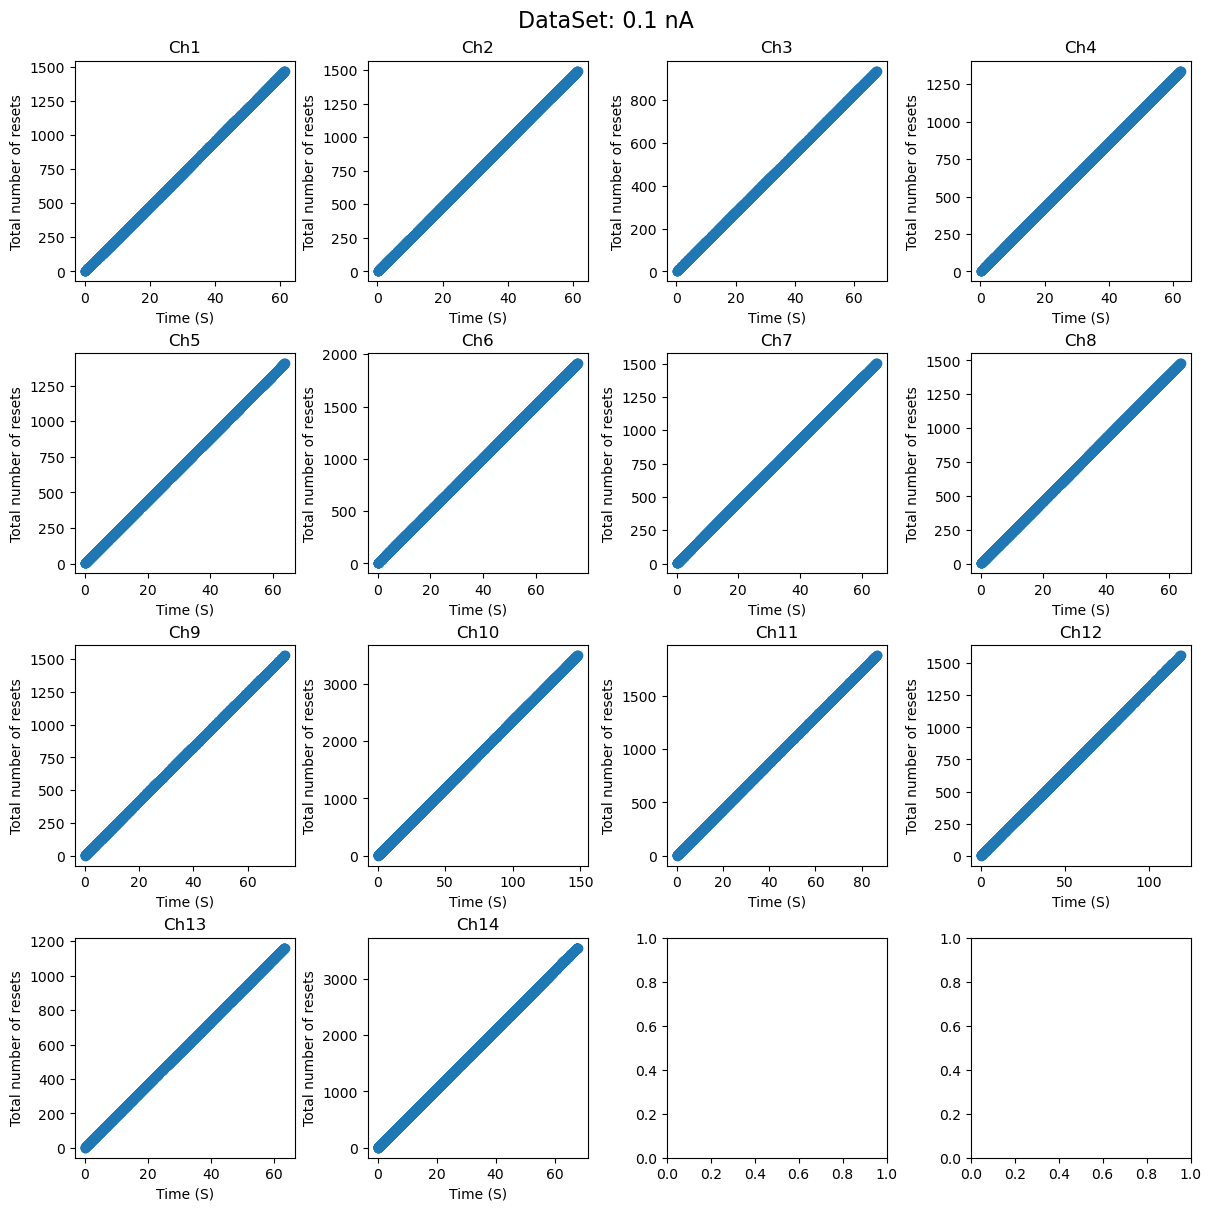

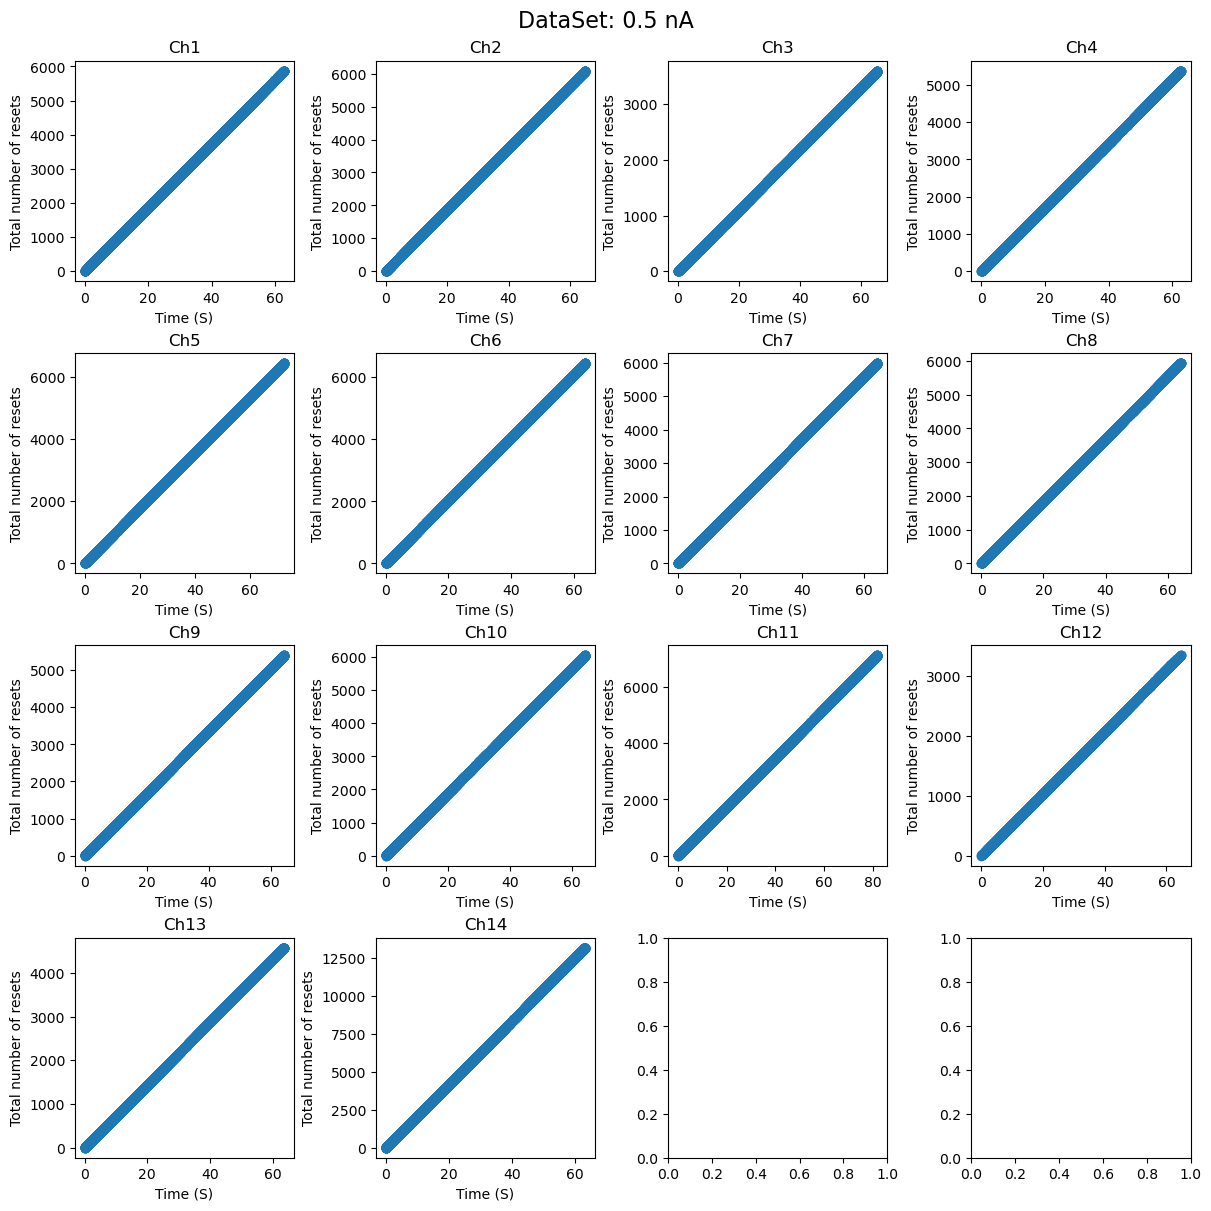

In [4]:
allInputCurrentNames = ['0.01 nA', '0.07 nA', '0.1 nA', '0.5 nA']
allInputCurrentSaveNames = ['0p01nA', '0p07nA', '0p1nA', '0p5nA']

num=0
for value in allInputCurrents:
    num += 1
    
    # Initialize a list to hold the 14 lists of total number of resets at each time (will be 12345...end)
    totNumResets = [[] for _ in range(14)]
    for n in range(0, len(totNumResets)):
        totalResetNum= len(value[n])
        totResetsNow = 0
        for num2 in range (0, totalResetNum):
            totResetsNow +=1
            totNumResets[n].append(totResetsNow)
            
    # Define the number of rows and columns for subplots
    num_rows, num_cols = 4, 4

    # Create the subplots with tight layout
    fig2, axs2 = plt.subplots(num_rows, num_cols, figsize=(12, 12), constrained_layout=True)

    # Flatten the axs array for easier iteration
    axs2 = axs2.ravel()

    # Loop through your data
    for i in range(0, len(value)):
        # Check if there is more than one reset data point to avoid division by 0 error
        if len(value[i]) > 1:
            axs2[i].scatter(value[i], totNumResets[i])
            axs2[i].set_xlabel("Time (S)")
            axs2[i].set_ylabel("Total number of resets")
            axs2[i].set_title("Ch{}".format(i + 1))

    fig2.suptitle('DataSet: '+ allInputCurrentNames[num-1], fontsize=16)
    fig2.savefig(input_file.split('Package')[0] + 'Package/Plots/ResetsVsTime/' + allInputCurrentSaveNames[num-1] + '.png')


## 3. Get the Reset Time differences and plotting:

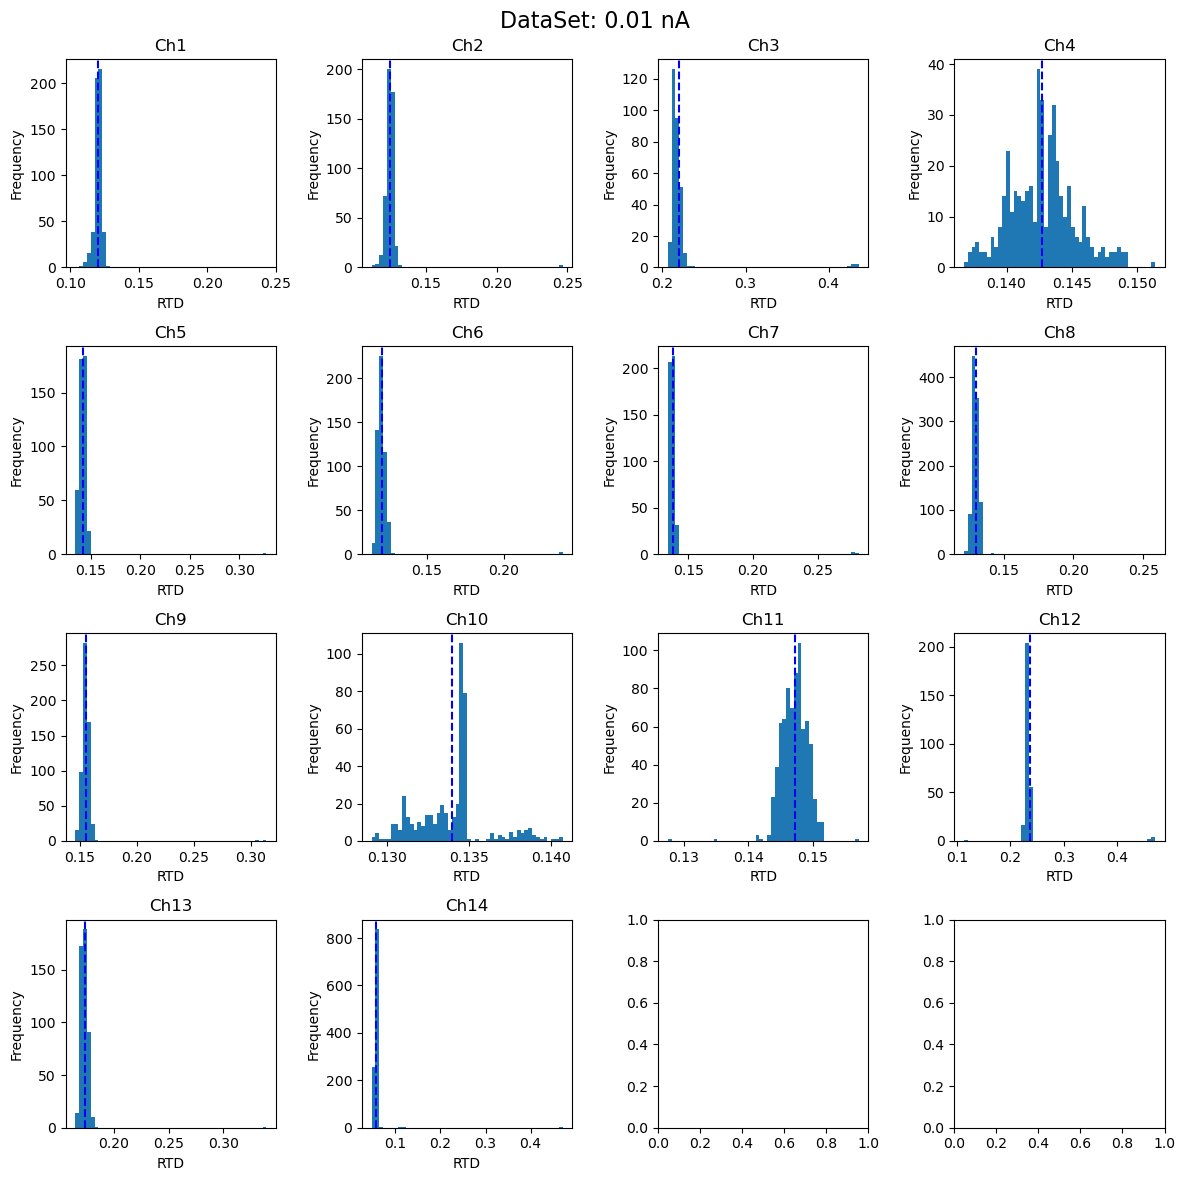

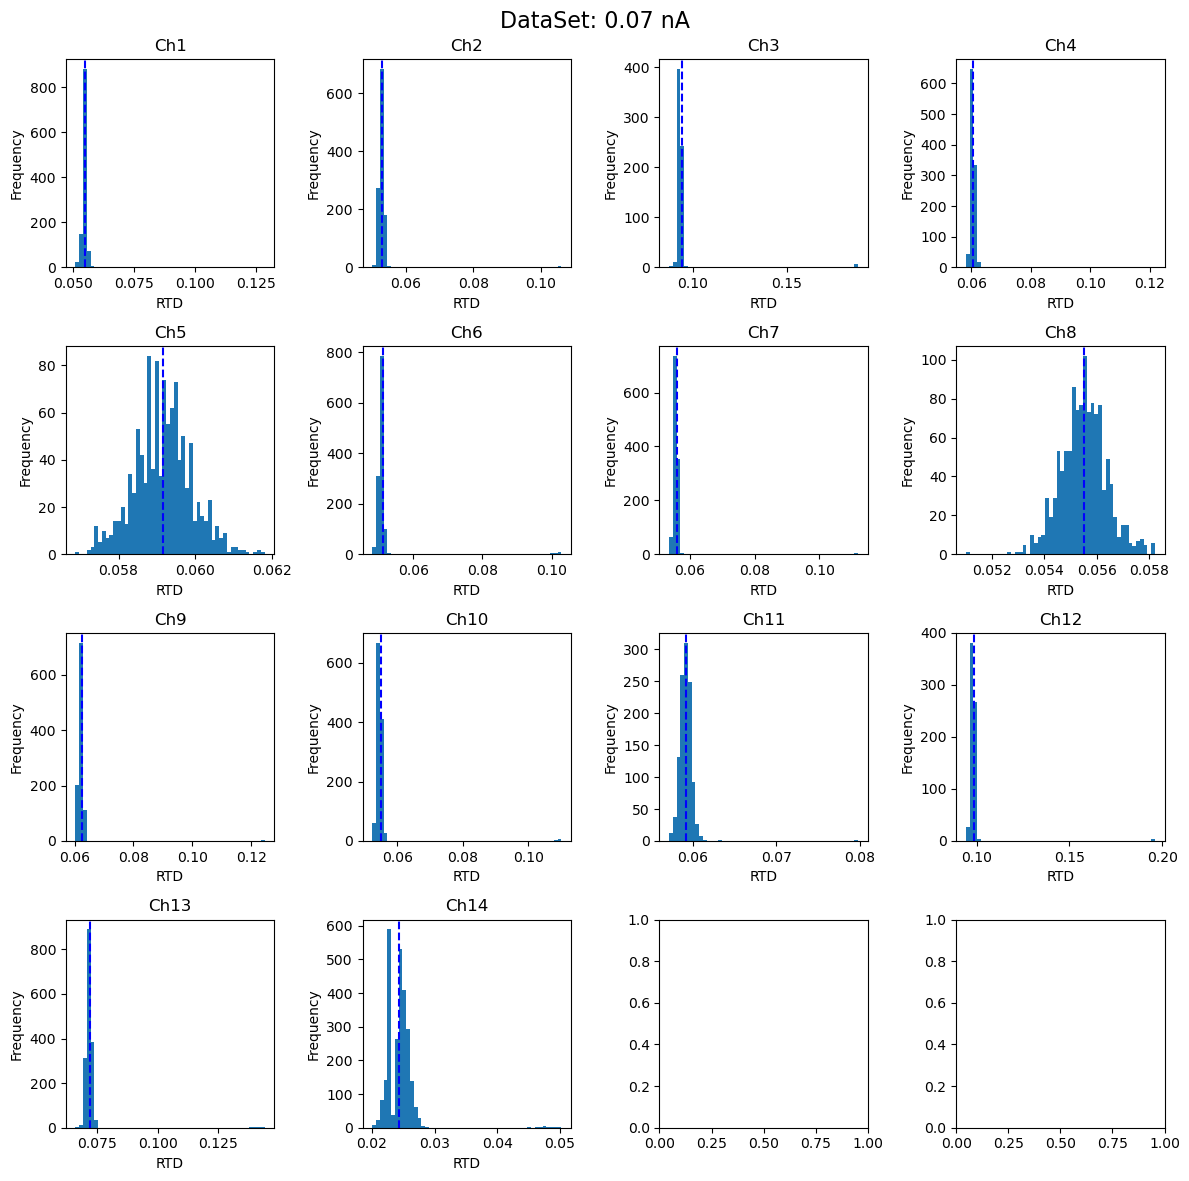

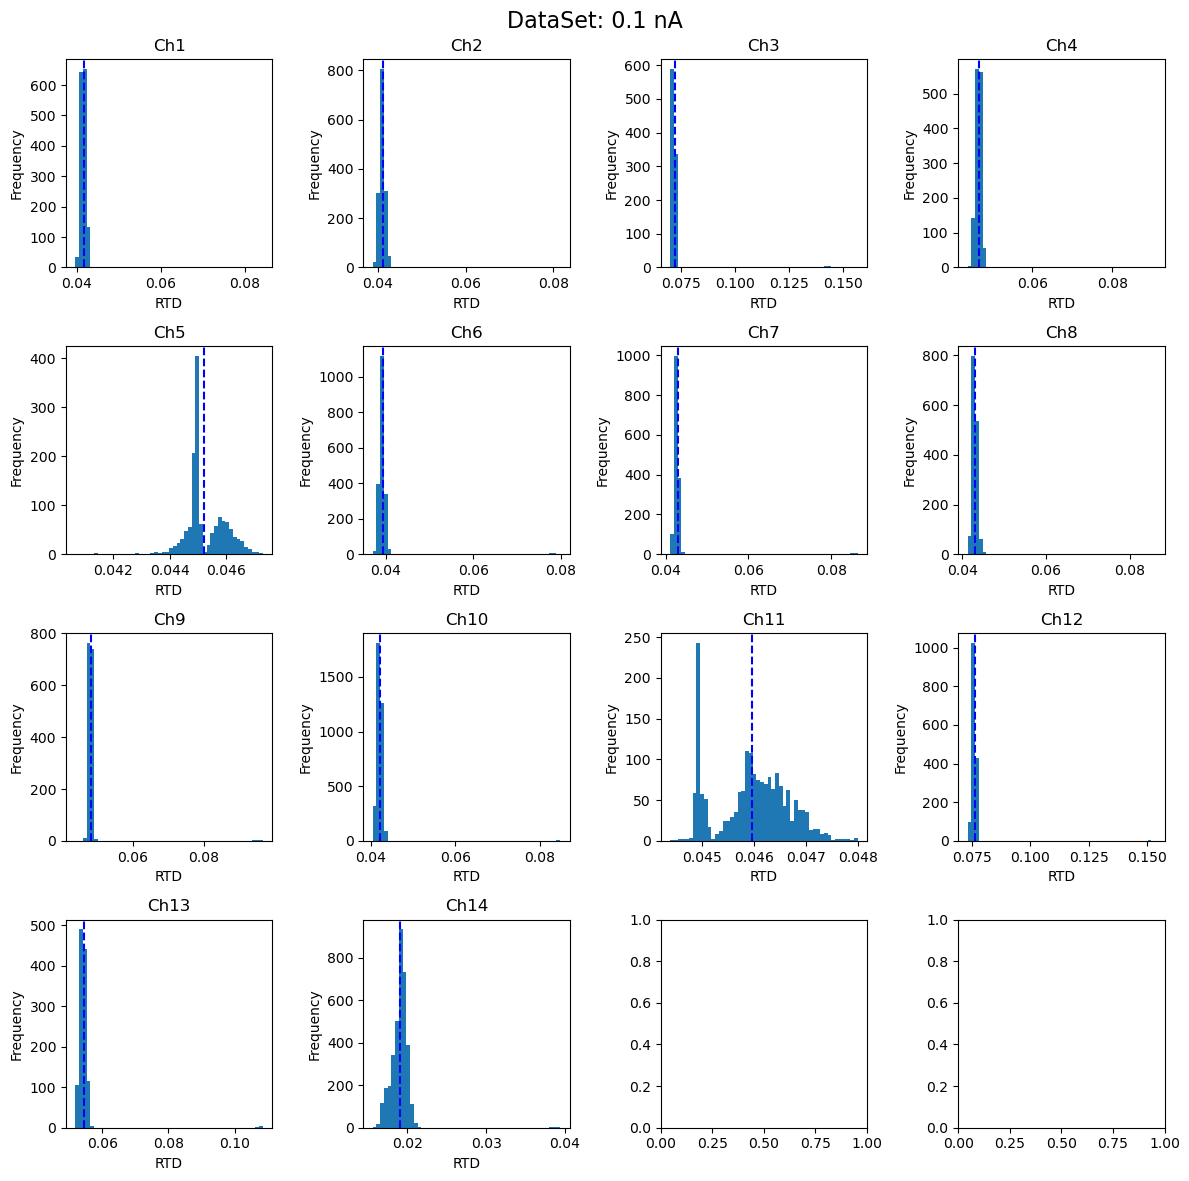

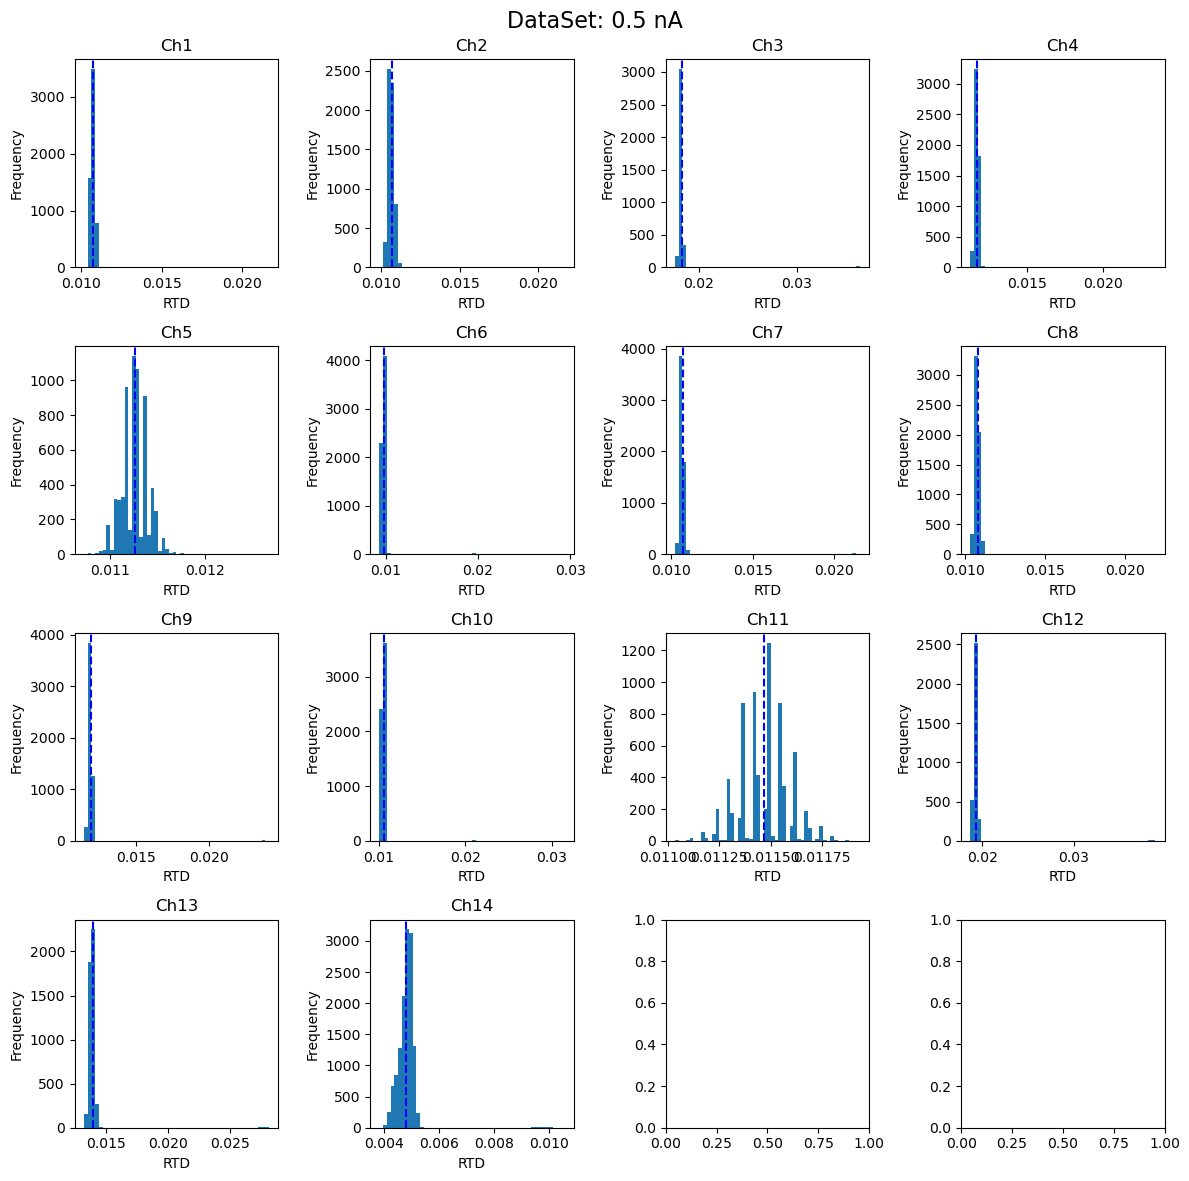

In [74]:
eachCurrentRTDHolder=[]

allInputCurrentNames = ['0.01 nA', '0.07 nA', '0.1 nA', '0.5 nA']
allInputCurrentSaveNames = ['0p01nA', '0p07nA', '0p1nA', '0p5nA']

# Go through each individual input current value and do analysis
#value is a 14 index list
num=0
for value in allInputCurrents:
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    axs = axs.ravel()
    # Initialize a list to hold the 16 lists of reset time differences for data
    reset_time_diffs = [[] for _ in range(14)]
  
    # Iterate over the elements of 'value' using enumeration
    for i, timeStamps in enumerate(value):
        
        # Check if there are rtds, if not leave the list empty as it already is
        if len(timeStamps) > 0:
            rtd_list = []
            for index in range(0,len(timeStamps)):
                if index !=0:
                    rtd = timeStamps[index]-timeStamps[index - 1]
                    rtd_list.append(rtd)
            reset_time_diffs[i] = [num for num in rtd_list]

        # Need to make this greater than one reset because otherwise there is a division by 0 error
        if len(reset_time_diffs[i]) > 1:

            meanRtd = np.mean(reset_time_diffs[i])
            axs[i].hist(reset_time_diffs[i], bins=50) # loook into this function for bins
            axs[i].axvline(meanRtd, color='blue', linestyle='--')
            axs[i].set_xlabel("RTD")
            axs[i].set_ylabel("Frequency")
            axs[i].set_title("Ch{}".format(i + 1))
    fig.suptitle('DataSet: ' + allInputCurrentNames[num], fontsize=16)
    fig.tight_layout()
    fig.savefig(input_file.split('Package')[0] + 'Package/Plots/RtdSpread/' + allInputCurrentSaveNames[num] + '.png')

    eachCurrentRTDHolder.append(reset_time_diffs)
    num+=1

## 4. Calculating Charge Per Reset from Calibration Data:

In [75]:
allInputCurrentNames = ['0.01 nA', '0.07 nA', '0.1 nA', '0.5 nA']
allInputCurrentSaveNames = ['0p01nA', '0p07nA', '0p1nA', '0p5nA']

# Go through each individual input current value and do analysis
#value is a 14 index list
num=0
averageRtdLists=[]
stdevs=[]
for value in eachCurrentRTDHolder:
    thisCurrentAverages = [[] for _ in range(14)]
    thisCurrentstdevs = [[] for _ in range(14)]
    chnum=0
    for ch in value: #go to each channel
        thisCurrentAverages[chnum]=np.average(ch) #get average RTD
        thisCurrentstdevs[chnum] = np.std(ch) #get standard deviation of RTD spread
        chnum += 1  #get the channel number
        
    averageRtdLists.append(thisCurrentAverages)
    stdevs.append(thisCurrentstdevs)
    n+=1

chargePerReset=[] #14 charges for each channel for this directory, each from slope of lin lits to 4 diff currents
errsChargePerReset=[]
for i in range(14):
    y = [0.01*(1e-9), 0.07*(1e-9), 0.1*(1e-9), 0.5*(1e-9)]
    x = [1 / averageRtdLists[0][i], 1 / averageRtdLists[1][i], 1 / averageRtdLists[2][i], 1 / averageRtdLists[3][i]]
    xerr=[   stdevs[0][i]/((averageRtdLists[0][i])**2),    stdevs[1][i]/((averageRtdLists[1][i])**2),      stdevs[2][i]/((averageRtdLists[2][i])**2) ,   stdevs[3][i]/((averageRtdLists[3][i])**2)]

    # Define the degree of the polynomial fit (1 for linear fit)
    degree = 1

    # Calculate the weights based on the inverse of the errors
    weights = [1 / err for err in xerr]
    
    # Perform the weighted polynomial fit using numpy.polyfit
    coefficients, cov_matrix = np.polyfit(x, y, degree, w=weights, cov=True)
    
    # Calculate slope error (chargePerReset error) from covariance matrix
    slope_error = np.sqrt(cov_matrix[1][1])  

    polynomial = np.poly1d(coefficients)
    line_of_best_fit = polynomial(x)

    chargePerReset.append(coefficients[0])
    errsChargePerReset.append(slope_error)


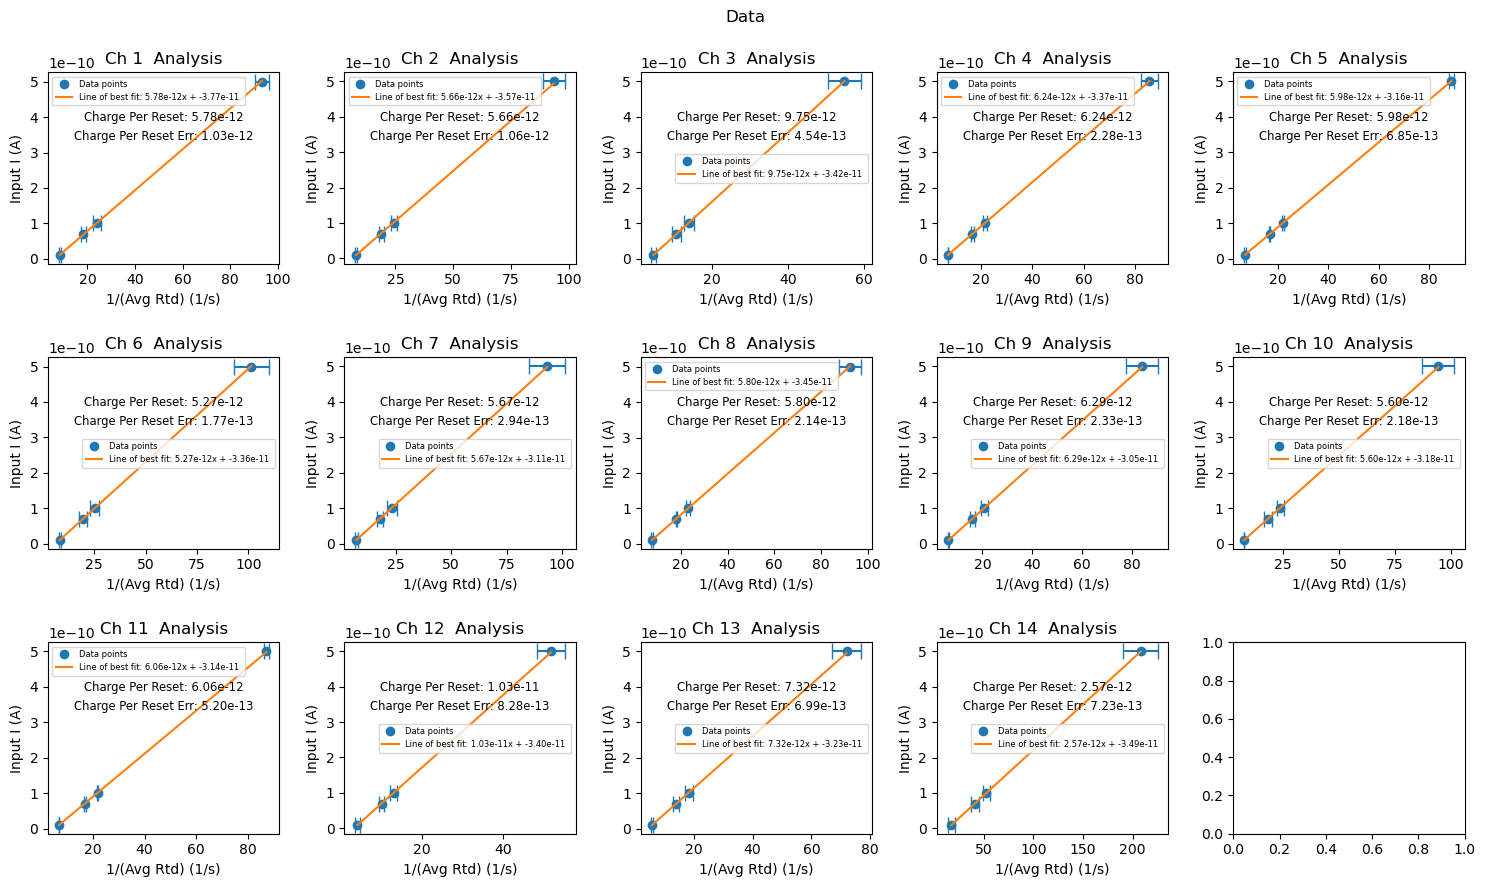

In [76]:
#plot the fits

fig, axs = plt.subplots(3, 5, figsize=(15, 9))

# Flatten the axs array for easy iteration
axs = axs.flatten()
chargePerResetErr = []
chargePerReset=[]
for i in range(14):
    y = [0.01*(1e-9), 0.07*(1e-9), 0.1*(1e-9), 0.5*(1e-9)]
    x = [1 / averageRtdLists[0][i], 1 / averageRtdLists[1][i], 1 / averageRtdLists[2][i], 1 / averageRtdLists[3][i]]
    xerr=[stdevs[0][i]/((averageRtdLists[0][i])**2),  stdevs[1][i]/((averageRtdLists[1][i])**2),   stdevs[2][i]/((averageRtdLists[2][i])**2) , stdevs[3][i]/((averageRtdLists[3][i])**2)]

    # Define the degree of the polynomial fit (1 for linear fit)
    degree = 1

    # Calculate the weights based on the inverse of the errors
    weights = [1 / err for err in xerr]
    
    # Perform the weighted polynomial fit using numpy.polyfit
    coefficients, cov_matrix = np.polyfit(x, y, degree, w=weights, cov=True)
    slope_error = np.sqrt(cov_matrix[1][1]) 
    
    
    polynomial = np.poly1d(coefficients)
    line_of_best_fit = polynomial(x)

    chargePerReset.append(coefficients[0])
    chargePerResetErr.append(slope_error)
    
    # Plot the data points

    
    # Plot the line of best fit and data points and errorbars
    axs[i].plot(x, y, 'o', label='Data points')
    axs[i].errorbar(x, y, xerr=(xerr, xerr), fmt='none', capsize=6, markersize='6')
    axs[i].plot(x, line_of_best_fit, label=f'Line of best fit: {coefficients[0]:.2e}x + {coefficients[1]:.2e} ')

    # Create legend entries dynamically
    legend_entries = [
      'Data points',
      f'Line of best fit',
    ]
    
    # Get y axis limits for text placement
    ymin, ymax = axs[i].get_ylim()
    
    # Print ChargePerResetErr below the legend with spacing
    axs[i].text(
        0.5, ymin + 0.7 ,
        f'Charge Per Reset Err: {slope_error:.2e}',
        ha='center', va='top', fontsize='small', color='black', transform=axs[i].transAxes
    )
    axs[i].text(
        0.5, ymin + 0.8 ,
        f'Charge Per Reset: {coefficients[0]:.2e}',
        ha='center', va='top', fontsize='small', color='black', transform=axs[i].transAxes
    )
    
    # Add legend with all entries
    axs[i].legend(legend_entries, loc='upper left', fontsize='small')

    # Set labels and title for the subplot
    axs[i].set_xlabel('1/(Avg Rtd) (1/s)')
    axs[i].set_ylabel('Input I (A)')
    axs[i].set_title('Ch ' + str(i+1) + '  Analysis')

    # Show legend with smaller font size
    axs[i].legend(fontsize=6)

# Adjust layout for better spacing
fig.suptitle(str(dir.split('/')[-1]))

fig.tight_layout()
fig.savefig(input_file.split('Package')[0] + 'Package/Plots/CalibrationFit/' + 'ChargePerResetFit.png')


## 5. Comparing Charge Per Reset to Vdd Values:

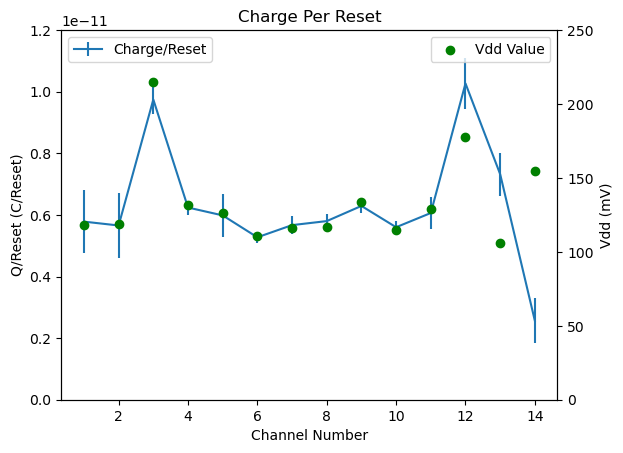

In [77]:
# Make charge per Reset vs Vdd plot
plt.figure()

#Feducialize at ch 12 can be justified because of the E feilds on 13/14, but in rewlity I remove them becaue the Vdd values are far off here

ch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
QperReset = chargePerReset[:14]
err = chargePerResetErr[:14]

plt.title('Charge Per Reset')
plt.ylabel('Q/Reset (C/Reset)')
plt.xlabel('Channel Number')
plt.errorbar(ch,QperReset, yerr=(err, err),label='Charge/Reset')
plt.legend(loc='upper left')
plt.ylim(0, 1.2e-11)

plt.twinx()

# Plot the Vdd value as we measured it in the lab on the second y-axis to compare the shapes:
vddch = [118,119,215,132,126,111,116,117,134,115,129,178,106,155] #our last three vdd values are off
plt.scatter(ch, vddch, color='green', label='Vdd Value')
plt.ylabel('Vdd (mV)')
plt.legend(loc='upper right')
plt.ylim(0, 250)
    
# plt.errorbar(xnumRtds, y, yerr=yer, xerr=xer, fmt='o', markersize=2, linewidth=0.01, capsize=8, color='black', ecolor='red')
plt.savefig(input_file.split('Package')[0] + 'Package/Plots/ChargePerReset/' + 'ChargePerReset.png')